# LSTM Portfolio


## Preprocessing

In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

start_date = '2000-01-01'
end_date = '2024-02-19'
start_date = pd.to_datetime(start_date)
end_date   = pd.to_datetime(end_date)


df = yf.download(tickers = symbols_list,
            start   = start_date,
            end     = end_date).stack()

[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1708318800")


In [3]:
data = df

data.index.names = ['date', 'ticker']
data.columns = df.columns.str.lower()
data['dollar_volume'] = (data['adj close']*data['volume'])/1e6

In [4]:
data =  data.drop(columns=['close', 'high', 'low', 'open', 'volume'])
data

Price               adj close  dollar_volume
date       ticker                           
2000-01-03 A        43.613022     203.862660
           AAPL      0.846127     453.352125
           ABT       8.992849      95.639735
           ACGL      1.277778       0.554300
           ADBE     16.274673     120.178699
...                       ...            ...
2024-02-16 XYL     123.430000     149.066411
           YUM     133.880005     343.522705
           ZBH     124.475929     181.162267
           ZBRA    275.459991     181.307766
           ZTS     187.854370     367.011083

[2708530 rows x 2 columns]

In [5]:
# Filter for companies with no nulls
nas = data.unstack()['adj close'].isna().sum()
tickers = nas[nas ==0].index
data = data.loc[data.index.get_level_values('ticker').isin(tickers)]
data.isna().sum()

Price
adj close        0
dollar_volume    0
dtype: int64

Filter for most 150 liquid stocks

In [6]:
filtered = data.unstack()['dollar_volume'].resample('BM').mean().stack().to_frame('dollar_volume')
filtered = filtered.unstack().rolling(5*12, min_periods=12).mean().stack()
filtered['dollar_vol_rank'] = (filtered.groupby('date')['dollar_volume'].rank(ascending=False))
filtered = filtered[filtered['dollar_vol_rank']<150]

In [7]:
cols = filtered.unstack().columns
tickers = set()
for i in range(cols.shape[0]):
  tickers.add(cols[i][1])

In [8]:
data = data.loc[data.index.get_level_values('ticker').isin(tickers)].drop('dollar_volume', axis=1)

In [9]:
# import pickle
# with open("data.pkl", "wb") as file:
#   pickle.dump(data, file)

In [10]:
# import pickle
# with open("data.pkl", "rb") as file:
#   data = pickle.load(file)

## Run LSTM model for each company to get monthly predictions

1. Get dataframes of sliding windows for all stocks
2. Train LSTM on all dataframes -> get predictions
3. For each month, get top 15 (only if positive) stocks with greatest price increase
4. Calculate return for portfolio
5. Plot return and compare to unsupervised cluster portfolio

### Get predictions

In [11]:
## get rolling windows
def get_sequences(df_local, lag=60):
  eom = df_local.resample('BM').last().sort_index()

  Y = eom[3:]

  all_y = []
  all_X = []

  for i in range(len(Y)):
    y = Y.iloc[i]
    X = df_local[(df_local.index < y.name)][-lag:]

    all_y.append(y)
    all_X.append(X)

  X = pd.DataFrame(np.hstack([x.values for x in all_X]).transpose())
  # y = pd.Series([y.values[0] for y in all_y])
  y = pd.DataFrame(all_y)
  X.index = y.index

  return X, y

**Warning:** the below cell takes hours to run.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob
import gc

tickers_done = glob('/content/drive/MyDrive/LSTM/*.csv')
tickers_done = set([x.split('/')[-1].split('.')[0] for x in tickers_done])

tickers = tickers.difference(tickers_done)

predictions = pd.DataFrame()
split = int((len(data.unstack().resample("BM").last())-3)*0.8)
predictions.index = data.unstack().resample("BM").last().iloc[split+3:].index

for ticker in tqdm(list(tickers)):

  print(ticker)

  X, y = get_sequences(pd.DataFrame(data.unstack()['adj close', ticker]).tz_localize('America/New_York'))
  sc = MinMaxScaler(feature_range=(0, 1))
  X_scaled = sc.fit_transform(X)
  y_scaled = sc.fit_transform(y)

  split = int(X_scaled.shape[0] * 0.8)

  X_train = X_scaled[:split]
  y_train = y_scaled[:split]

  X_test = X_scaled[split:]
  y_test = y_scaled[split:]

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  regressor = Sequential()

  regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
  regressor.add(Dropout(0.3))

  regressor.add(LSTM(units=80, return_sequences=True))
  regressor.add(Dropout(0.1))

  regressor.add(LSTM(units=50, return_sequences=True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units=30))
  regressor.add(Dropout(0.3))

  regressor.add(Dense(units=1))

  regressor.compile(optimizer='adam',loss='mean_squared_error')

  regressor.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

  predicted_stock_price = regressor.predict(X_test)
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)

  # predictions[ticker] = predicted_stock_price

  predicted_stock_price = pd.Series(predicted_stock_price[:,0])
  predicted_stock_price.index = predictions.index
  predicted_stock_price.to_csv('/content/drive/MyDrive/LSTM/%s.csv' % ticker)

  del regressor
  gc.collect()

0it [00:00, ?it/s]


In [14]:
fnames = glob('/content/drive/MyDrive/LSTM/*.csv')
predictions = pd.DataFrame()
for fname in fnames:
  ticker = fname.split('/')[-1].split('.')[0]
  predictions[ticker] = pd.read_csv(fname, index_col=0)['0']

<ipython-input-14-c3b6e8118484>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions[ticker] = pd.read_csv(fname, index_col=0)['0']
<ipython-input-14-c3b6e8118484>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions[ticker] = pd.read_csv(fname, index_col=0)['0']
<ipython-input-14-c3b6e8118484>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

### For each month, pick out top 15 stocks

In [16]:
tickers = set(predictions.columns)
actual = yf.download(tickers=tickers, start=predictions.index[0], end=predictions.index[-1])
actual = actual.resample('BM').first()

[*********************100%%**********************]  222 of 222 completed


In [29]:
predictions.index = pd.to_datetime(predictions.index)

In [30]:
change = predictions.pct_change().apply(lambda x: x.nlargest(15))
change.index = change.index - pd.offsets.MonthBegin(1)
tickers = change.loc['2019-06-01'].dropna().index.tolist()

portfolio = {}

for date in change.index:
  portfolio[date.strftime('%Y-%m-%d')] = change.loc[date].dropna().index.tolist()


### Calculate returns

In [31]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.7 MB/s eta 0:00:00


In [32]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


In [34]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=predictions.index[0]-pd.DateOffset(months=12),
                     end=predictions.index[-1])

new_df

[*********************100%%**********************]  222 of 222 completed


Price        Adj Close                                                  \
Ticker               A        AAPL         ABT        ADBE         ADI   
Date                                                                     
2018-05-31   59.231400   44.471134   55.550392  249.279999   86.663994   
2018-06-01   60.054062   45.273129   56.344875  251.309998   87.751984   
2018-06-04   60.628014   45.651512   56.895592  253.339996   89.160988   
2018-06-05   60.761921   46.003731   56.904613  252.699997   89.749573   
2018-06-06   62.359417   46.163170   57.365055  253.949997   91.051582   
...                ...         ...         ...         ...         ...   
2024-02-22  131.805878  184.369995  118.432640  537.570007  191.009933   
2024-02-23  131.815857  182.520004  118.870468  553.440002  189.218369   
2024-02-26  131.276749  181.160004  118.104271  560.479980  188.123535   
2024-02-27  132.335022  182.630005  118.810768  552.489990  188.183258   
2024-02-28  136.787781  181.419998  119.457558  551.820007  186.879395   

Price                                                                ...  \
Ticker            ADM         ADP        ADSK        AES        AFL  ...   
Date                                                                 ...   
2018-05-31  37.371536  114.655640  129.100006  10.657722  39.208984  ...   
2018-06-01  37.457012  117.045364  133.520004  10.691159  39.504837  ...   
2018-06-04  37.687809  118.385765  135.570007  10.808185  39.530930  ...   
2018-06-05  37.807472  118.227036  136.800003  10.808185  39.548340  ...   
2018-06-06  38.286156  120.017174  137.929993  10.457107  39.765877  ...   
...               ...         ...         ...        ...        ...  ...   
2024-02-22  53.700001  253.296829  256.980011  16.000000  79.650002  ...   
2024-02-23  53.450001  254.400452  257.200012  16.000000  80.410004  ...   
2024-02-26  53.169998  252.093781  257.350006  15.550000  79.699997  ...   
2024-02-27  52.790001  249.866638  256.950012  15.100000  80.209999  ...   
2024-02-28  53.009998  250.115204  255.250000  15.060000  80.559998  ...   

Price         Volume                                                          \
Ticker            VZ     WAT       WBA      WDC       WFC       WM       WMB   
Date                                                                           
2018-05-31  27288300  820600   6508700  4896100  17515900  3413900   9735300   
2018-06-01   9967100  436100   3225500  3748700  14100200  1541200   7680500   
2018-06-04   9012600  552200   3564200  4238300  10593700  1949500  10067200   
2018-06-05  10378000  406800   6999100  2851100  11883900  1706600   7578600   
2018-06-06  12924800  753800   5455600  4804000  15848200  1559300  11523800   
...              ...     ...       ...      ...       ...      ...       ...   
2024-02-22  22068900  364900  11972600  5101200  20467900  2267600   9328500   
2024-02-23  15228600  241800  31886700  3163600  20863500  1687000   5749600   
2024-02-26  25108400  329700  13650200  6165000  18099900  1664300   5804200   
2024-02-27  17074100  219200   9055000  6304300  19548200  1208100   8672800   
2024-02-28  12437000  583200   8841200  4133900  20045200  1705600   8243100   

Price                                    
Ticker           WMT       XOM      YUM  
Date                                     
2018-05-31  34406100  15803100  5390400  
2018-06-01  15713700   9906100  1978600  
2018-06-04  32766000  10954700  1464400  
2018-06-05  24844200  12059300  1940900  
2018-06-06  22088400  11603300  2843300  
...              ...       ...      ...  
2024-02-22  29512800  20470700  2328100  
2024-02-23  74365800  15975900  1592200  
2024-02-26  32154800  13360800  1769800  
2024-02-27  18012700  16360000  1827100  
2024-02-28  14803300  14810500  1417500  

[1446 rows x 1332 columns]

In [42]:
returns_dataframe = np.log(new_df['Adj Close']).diff()


def portfolio_optimization(fixed_dates):

  portfolio_df = pd.DataFrame()

  for start_date in fixed_dates.keys():

      try:

          end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

          cols = fixed_dates[start_date]

          optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

          optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

          optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

          success = False
          try:
              weights = optimize_weights(prices=optimization_df,
                                    lower_bound=round(1/(len(optimization_df.columns)*2),3))

              weights = pd.DataFrame(weights, index=pd.Series(0))

              success = True
          except:
              print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

          if success==False:
              weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                      index=optimization_df.columns.tolist(),
                                      columns=pd.Series(0)).T

          temp_df = returns_dataframe[start_date:end_date]

          temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                            left_index=True,
                            right_index=True)\
                    .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

          temp_df.index.names = ['date', 'ticker']

          temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

          temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

          portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

      except Exception as e:
          print(e)

  portfolio_df = portfolio_df.drop_duplicates()

  return portfolio_df

result = portfolio_optimization(portfolio)

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights


In [ ]:
result.index[0].strftime('%Y-%m-%d')

In [43]:
spy = yf.download(tickers='SPY',
                  start=result.index[0].strftime('%Y-%m-%d'),
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = result.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
import pickle
f = open('portfolio_cumulative_return.pkl', 'wb')
pickle.dump(portfolio_cumulative_return, f)
f.close()

portfolio_cumulative_return = pickle.load('portfolio_cumulative_return.pkl')

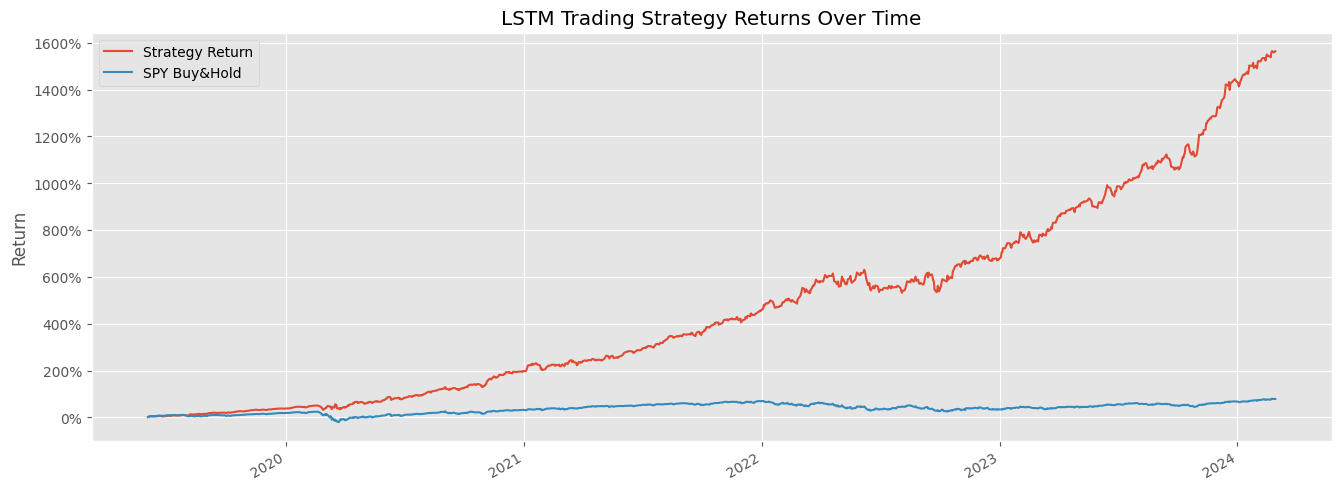

In [45]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:].plot(figsize=(16,6))

plt.title('LSTM Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
